<a href="https://colab.research.google.com/github/Derinhelm/parser_stat/blob/main/Russian_parser_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скачивание SynTagRus (тестовая часть)

In [1]:
!wget -m https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu
!mv /content/raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu /content/ru_syntagrus-ud-test.conllu
!rm -r /content/raw.githubusercontent.com

--2024-08-15 15:10:33--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14970966 (14M) [text/plain]
Saving to: ‘raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu’

raw.githubuserconte 100%[===================>]  14.28M  35.6MB/s    in 0.4s    

Last-modified header missing -- time-stamps turned off.
2024-08-15 15:10:35 (35.6 MB/s) - ‘raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu’ saved [14970966/14970966]

FINISHED --2024-08-15 15:10:35--
Total wall clock time: 2.1s
Downloaded: 1 files, 14M in 0.4s (35.6 MB/s)


# Получение информации из SynTagRus

In [2]:
class ConllEntry:
    def __init__(self, id, form=None, lemma=None, pos=None, cpos=None, feats=None, \
                 parent_id=None, relation=None,deps=None, misc=None):
        self.id = id
        self.form = form
        self.lemma = lemma
        self.pos = pos
        self.cpos = cpos
        self.feats = feats
        self.parent_id = parent_id
        self.relation = relation
        self.deps = deps
        self.misc = misc

In [3]:
class Sentence:
    def __init__(self):
        self.text = ""
        self.sent_id = ""
        self.tokens = []

    def add_token(self, token):
        self.tokens.append(token)

    def set_sent_id(self, sent_id):
        self.sent_id = sent_id

    def set_text(self, text):
        self.text = text

    def is_not_empty(self):
        return len(self.tokens) > 0

In [4]:
def get_dataset_sentences(dataset_path):
    fh = open(dataset_path,'r',encoding='utf-8')
    sents_read = 0
    sents = []
    comments = set()

    sent = Sentence()
    for line in fh:
        tok = line.strip().split('\t')
        if not tok or line.strip() == '': # empty line, add sentence to list
            if sent.is_not_empty:
                sents_read += 1
                sents.append(sent)
            sent = Sentence()
        else:
            if line[0] == '#' or '-' in tok[0]: # a comment line
                line = line.strip()
                if line[:12] == "# sent_id = ":
                    sent.set_sent_id(line[12:])
                elif line[:9] == "# text = ":
                    sent.set_text(line[9:])
                else:
                    comments.add(line)

            else: # an actual ConllEntry, add to tokens
                if tok[2] == "_":
                    tok[2] = tok[1].lower()
                if not "." in tok[0]:
                    token = ConllEntry(*tok)
                    sent.add_token(token)
    fh.close()
    return sents

In [5]:
all_sents = get_dataset_sentences("/content/ru_syntagrus-ud-test.conllu")

In [6]:
len(all_sents)

8800

Проверка, что все sent_id в тестовой выборке датасета разные.

In [7]:
len({s.sent_id for s in all_sents}) == len(all_sents)

True

In [8]:
from collections import OrderedDict
sents = OrderedDict()
for s in all_sents:
  sents[s.sent_id] = s

In [9]:
len(sents)

8800

# Загрузка результатов

In [10]:
parser_names = ["udpipe", "stanza", "natasha", "deeppavlov", "spacy"]

In [11]:
res = {}

In [12]:
import pickle

In [13]:
pickle_res = {}
for p in parser_names:
    with open(p + '_parsing.pickle', 'rb') as f:
       pickle_res[p] = pickle.load(f)

In [14]:
res = {p: OrderedDict() for p in parser_names}
for p in parser_names:
  for s in pickle_res[p]:
      res[p][s.sent_id] = s

In [15]:
for p in parser_names:
  print(p, len(res[p]))

udpipe 8800
stanza 8800
natasha 8800
deeppavlov 8800
spacy 8800


# Creating token start-end pairs

In [16]:
def create_begin_end_list(sent_text_dict, token_sent_dict):
  token_begin_end_dict = {}
  for sent_id, sent_text_val in sent_text_dict.items():
    token_begin_end = []
    sent_text = sent_text_val.lower()
    del_prefix_len = 0
    tokens = token_sent_dict[sent_id]
    for t_i, t in enumerate(tokens):
      token_text = t.lower().replace('``', '"').replace("''", '"')
      t_start = sent_text.find(token_text)
      if t_start == -1:
        print("Error:", sent_id, f"sent_text:{sent_text}, t:{token_text}", t_i)
      else:
        token_begin_end.append((del_prefix_len + t_start,
                              del_prefix_len + t_start + len(token_text)))
        del_prefix_len += t_start + len(token_text)
        sent_text = sent_text[t_start + len(token_text):]
    for i, (b, f) in enumerate(token_begin_end):
      assert sent_text_val[b:f].lower() == tokens[i].lower().replace('``', '"').replace("''", '"')
    token_begin_end_dict[sent_id] = token_begin_end
  assert len(token_begin_end_dict) == len(sent_text_dict)
  assert len(token_begin_end_dict) == len(token_sent_dict)
  return token_begin_end_dict

In [17]:
sent_id_list = list(sents.keys())

syntagrus_begin_end_list = create_begin_end_list({sent_id: sents[sent_id].text for sent_id in sent_id_list},
                                                 {sent_id:[w.form for w in sents[sent_id].tokens] for sent_id in sent_id_list})
print(len(syntagrus_begin_end_list))

8800


In [18]:
syntagrus_begin_end_list['2003Armeniya.xml_11']

[(0, 1),
 (2, 9),
 (10, 21),
 (22, 27),
 (27, 28),
 (29, 39),
 (40, 52),
 (53, 64),
 (64, 65)]

In [19]:
res_begin_end_list = {}
for p in parser_names:
  res_begin_end_list[p] = create_begin_end_list({sent_id:sents[sent_id].text for sent_id in sent_id_list},
                                                 {sent_id: [w.form for w in res[p][sent_id].tokens]
                                                    for sent_id in sent_id_list})
  print(p, len(res_begin_end_list[p]))

udpipe 8800
stanza 8800
natasha 8800
deeppavlov 8800
spacy 8800


In [20]:
be_res = {p: {} for p in parser_names}
for p in parser_names:
  for sent_id in sent_id_list:
    sent_be_res = OrderedDict()
    for t_i, t in enumerate(res[p][sent_id].tokens):
      child_be = res_begin_end_list[p][sent_id][t_i]
      parent = t.parent_id
      if parent == '0': # root
        parent_be = (-1, -1)
      else:
        parent_be = res_begin_end_list[p][sent_id][int(parent) - 1]
      sent_be_res[child_be] = (parent_be, t.relation)
    be_res[p][sent_id] = sent_be_res
    assert len(be_res[p][sent_id]) == len(res[p][sent_id].tokens)
  assert len(be_res[p]) == len(res[p])

In [21]:
be_syntagrus = {}
for sent_id in sent_id_list:
  sent_be_syntagrus = OrderedDict()
  for t_i, t in enumerate(sents[sent_id].tokens):
    child_be = syntagrus_begin_end_list[sent_id][t_i]
    parent = t.parent_id
    if parent == '0': # root
      parent_be = (-1, -1)
    else:
      parent_be = syntagrus_begin_end_list[sent_id][int(parent) - 1]
    sent_be_syntagrus[child_be] = (parent_be, t.relation)
  be_syntagrus[sent_id] = sent_be_syntagrus
  assert len(be_syntagrus[sent_id]) == len(sents[sent_id].tokens)
assert len(be_syntagrus) == len(sents)

In [22]:
be_syntagrus['2003Artist_mimansa.xml_130']

OrderedDict([((0, 2), ((16, 20), 'nsubj')),
             ((3, 15), ((16, 20), 'advmod')),
             ((16, 20), ((-1, -1), 'root')),
             ((21, 24), ((25, 34), 'det')),
             ((25, 34), ((16, 20), 'obj')),
             ((35, 43), ((16, 20), 'advmod')),
             ((43, 44), ((16, 20), 'punct'))])

In [23]:
be_res['stanza']['2003Artist_mimansa.xml_130']

OrderedDict([((0, 2), ((16, 20), 'nsubj')),
             ((3, 9), ((16, 20), 'obl')),
             ((9, 10), ((10, 15), 'punct')),
             ((10, 15), ((3, 9), 'conj')),
             ((16, 20), ((-1, -1), 'root')),
             ((21, 24), ((25, 34), 'det')),
             ((25, 34), ((16, 20), 'obj')),
             ((35, 43), ((16, 20), 'advmod')),
             ((43, 44), ((16, 20), 'punct'))])

# Sentences with token set, not equal to SynTagRus token set for the sentence

In [24]:
sent_id = '2003Artist_mimansa.xml_130'
p = 'stanza'

In [25]:
wrong_token_amount = {}
for p in parser_names:
  wrong_token_amount[p] = set()
  for sent_id in sent_id_list:
    if set(be_syntagrus[sent_id].keys()) != set(be_res[p][sent_id].keys()):
      wrong_token_amount[p].add(sent_id)
for p in parser_names:
  print(p, len(wrong_token_amount[p]), f"{len(wrong_token_amount[p]) / len(sents):.2f}")

udpipe 274 0.03
stanza 216 0.02
natasha 722 0.08
deeppavlov 694 0.08
spacy 1103 0.13


In [26]:
any_wrong_token_amount = set()
for p in parser_names:
  any_wrong_token_amount |= set(wrong_token_amount[p])
print(len(any_wrong_token_amount), len(any_wrong_token_amount) / len(sents))

1569 0.17829545454545453


In [27]:
[(t.id + "_" + t.form, t.parent_id) for t in sents['2003Artist_mimansa.xml_130'].tokens]

[('1_Он', '3'),
 ('2_давным-давно', '3'),
 ('3_знал', '0'),
 ('4_всю', '5'),
 ('5_партитуру', '3'),
 ('6_наизусть', '3'),
 ('7_.', '3')]

In [28]:
[(t.id + "_" + t.form, t.parent_id) for t in res["stanza"]['2003Artist_mimansa.xml_130'].tokens]

[('1_Он', '5'),
 ('2_давным', '5'),
 ('3_-', '4'),
 ('4_давно', '2'),
 ('5_знал', '0'),
 ('6_всю', '7'),
 ('7_партитуру', '5'),
 ('8_наизусть', '5'),
 ('9_.', '5')]

# Sentence statistics

In [29]:
import pandas as pd

stat = {}
for p in parser_names:
  stat_list = []
  for sent_id in be_syntagrus:
    extra_syntagrus = len(be_syntagrus[sent_id].keys() - be_res[p][sent_id].keys())
    extra_parser = len(be_res[p][sent_id].keys() - be_syntagrus[sent_id].keys())
    tokenisation_matched = len({t_be for t_be in be_res[p][sent_id].keys() & be_syntagrus[sent_id].keys()})
    parent_matched = len({t_be for t_be in be_res[p][sent_id].keys() & be_syntagrus[sent_id].keys()
      if be_res[p][sent_id][t_be][0] == be_syntagrus[sent_id][t_be][0]})
    relation_matched = len({t_be for t_be in be_res[p][sent_id].keys() & be_syntagrus[sent_id].keys()
      if be_res[p][sent_id][t_be] == be_syntagrus[sent_id][t_be]})
    stat_list.append((sent_id, extra_syntagrus, extra_parser, tokenisation_matched,
                      parent_matched, relation_matched, len(sents[sent_id].tokens)))
  stat[p] = pd.DataFrame(stat_list, columns=['sent_id', 'extra_syntagrus', 'extra_parser', 'tokenisation_matched',
                                             'parent_matched', 'relation_matched', 'token_length'])

In [30]:
from collections import Counter

In [31]:
for p in parser_names:
  print(f"{p}.", f"syntagrus>parser:{sum((stat[p]['extra_syntagrus'] > stat[p]['extra_parser']))}, "
         , f"syntagrus<parser:{sum((stat[p]['extra_syntagrus'] < stat[p]['extra_parser']))}, "
         , f"syntagrus<parser:{sum((stat[p]['extra_syntagrus'] == stat[p]['extra_parser']) & (stat[p]['extra_parser'] > 0))}")

udpipe. syntagrus>parser:121,  syntagrus<parser:151,  syntagrus<parser:2
stanza. syntagrus>parser:125,  syntagrus<parser:89,  syntagrus<parser:2
natasha. syntagrus>parser:448,  syntagrus<parser:255,  syntagrus<parser:19
deeppavlov. syntagrus>parser:633,  syntagrus<parser:49,  syntagrus<parser:12
spacy. syntagrus>parser:272,  syntagrus<parser:797,  syntagrus<parser:34


In [32]:
align_uas_precision = {}
align_uas_recall = {}
align_las_precision = {}
align_las_recall = {}
align_uas_f = {}
align_las_f = {}
for p in parser_names:
  align_uas_precision[p] = stat[p]['parent_matched'] / (stat[p]['extra_parser'] + stat[p]['tokenisation_matched'])
  align_uas_recall[p] = stat[p]['parent_matched'] / (stat[p]['extra_syntagrus'] + stat[p]['tokenisation_matched'])
  align_las_precision[p] = stat[p]['relation_matched'] / (stat[p]['extra_parser'] + stat[p]['tokenisation_matched'])
  align_las_recall[p] = stat[p]['relation_matched'] / (stat[p]['extra_syntagrus'] + stat[p]['tokenisation_matched'])
  align_uas_f[p] = ((2 * align_uas_precision[p] * align_uas_recall[p]) / (align_uas_precision[p] + align_uas_recall[p])).fillna(0.0)
  align_las_f[p] = ((2 * align_las_precision[p] * align_las_recall[p]) / (align_las_precision[p] + align_las_recall[p])).fillna(0.0)
align_res = {"uas_precision": align_uas_precision,
             "uas_recall": align_uas_recall,
             "uas_f": align_uas_f,
             "las_precision": align_las_precision,
             "las_recall": align_las_recall,
             "las_f": align_las_f}

In [33]:
for p in parser_names:
  print(p, end = ". ")
  for a_res in align_res:
    print(f"{a_res}:{align_res[a_res][p].mean():.2f}", end = ", ")
  print()

udpipe. uas_precision:0.88, uas_recall:0.88, uas_f:0.88, las_precision:0.84, las_recall:0.84, las_f:0.84, 
stanza. uas_precision:0.92, uas_recall:0.92, uas_f:0.92, las_precision:0.90, las_recall:0.90, las_f:0.90, 
natasha. uas_precision:0.83, uas_recall:0.83, uas_f:0.83, las_precision:0.79, las_recall:0.78, las_f:0.78, 
deeppavlov. uas_precision:0.93, uas_recall:0.92, uas_f:0.92, las_precision:0.90, las_recall:0.89, las_f:0.89, 
spacy. uas_precision:0.87, uas_recall:0.87, uas_f:0.87, las_precision:0.82, las_recall:0.82, las_f:0.82, 


## All sentences (f-score)

Mean values of sentence f-score

In [34]:
for p in parser_names:
  p1 = p + "."
  print(f"{p1:11}", end = " ")
  for score_dict, title in [(align_uas_f, 'uas_f'), (align_las_f, 'las_f')]:
    print(f"{title}:{score_dict[p].mean():.2f}", end = ", ")
  print()

udpipe.     uas_f:0.88, las_f:0.84, 
stanza.     uas_f:0.92, las_f:0.90, 
natasha.    uas_f:0.83, las_f:0.78, 
deeppavlov. uas_f:0.92, las_f:0.89, 
spacy.      uas_f:0.87, las_f:0.82, 


Std values of sentence f-score

In [35]:
for p in parser_names:
  p1 = p + "."
  print(f"{p1:11}", end = " ")
  for score_dict, title in [(align_uas_f, 'uas_f'), (align_las_f, 'las_f')]:
    print(f"{title}:{score_dict[p].std():.2f}", end = ", ")
  print()

udpipe.     uas_f:0.16, las_f:0.17, 
stanza.     uas_f:0.16, las_f:0.17, 
natasha.    uas_f:0.17, las_f:0.18, 
deeppavlov. uas_f:0.13, las_f:0.14, 
spacy.      uas_f:0.17, las_f:0.18, 


Minimal uas/las

In [36]:
for p in parser_names:
  print(p, round(align_uas_f[p].min(), 2), round(align_las_f[p].min(), 2))

udpipe 0.0 0.0
stanza 0.0 0.0
natasha 0.0 0.0
deeppavlov 0.0 0.0
spacy 0.0 0.0


100% UAS/LAS

In [37]:
for p in parser_names:
  print(p, round(sum(align_uas_f[p] == 1.0) / len(sents), 2))

udpipe 0.38
stanza 0.54
natasha 0.27
deeppavlov 0.51
spacy 0.36


In [38]:
for p in parser_names:
  print(p, round(sum(align_las_f[p] == 1.0) / len(sents), 2))

udpipe 0.26
stanza 0.41
natasha 0.18
deeppavlov 0.37
spacy 0.22


UAS/LAS distributions without UAS/LAS, which are equal to 1.0

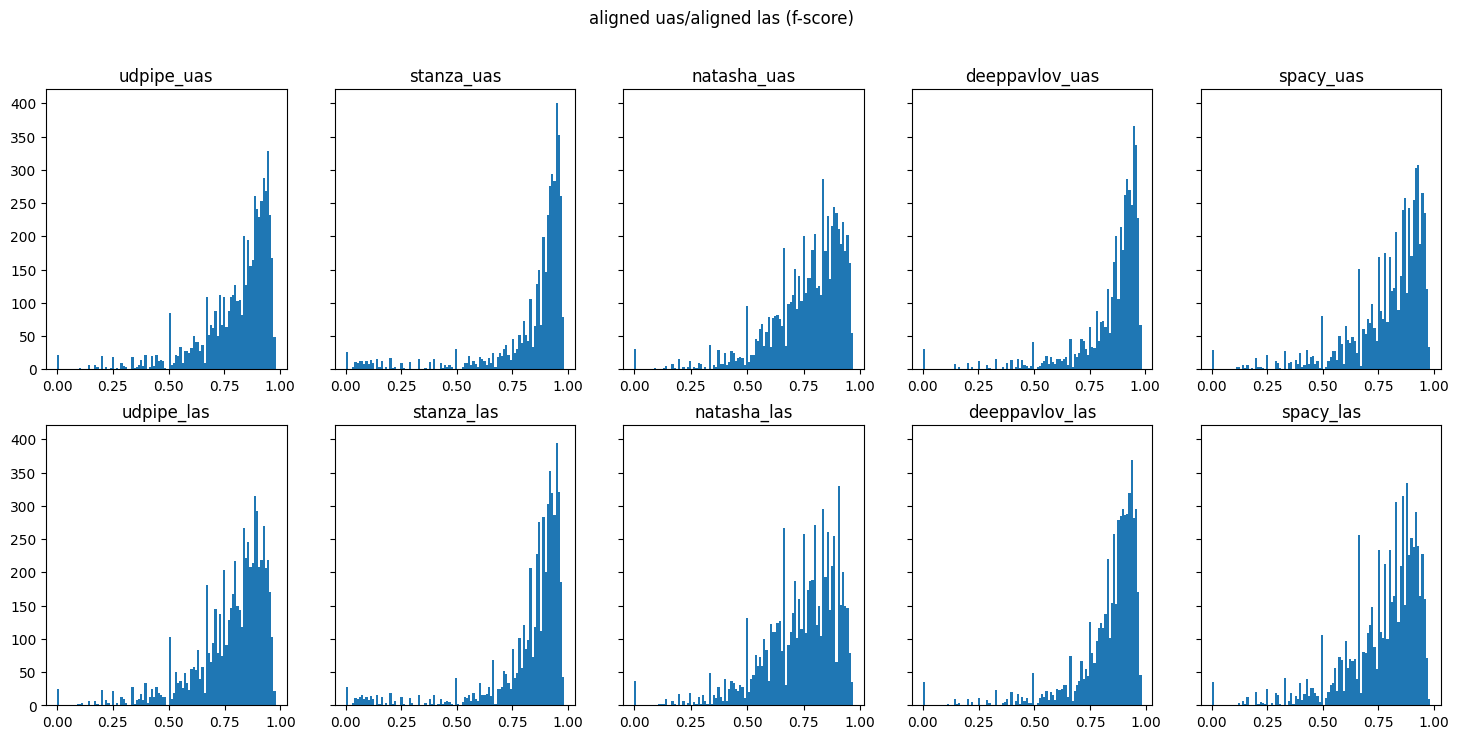

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols= len(parser_names), figsize = (18,8), sharey=True)
fig.suptitle('aligned uas/aligned las (f-score)')

for parser_i, p in enumerate(parser_names):
    ax[0, parser_i].hist([r for r in align_uas_f[p] if r != 1.0], bins=100)
    ax[0, parser_i].title.set_text(p + "_uas")
    ax[1, parser_i].hist([r for r in align_las_f[p] if r != 1.0], bins=100)
    ax[1, parser_i].title.set_text(p + "_las")

plt.savefig('uas_las_distributions.png')
plt.show()

UAS/LAS quantilies

In [40]:
for p in parser_names:
  print(p, round(align_uas_f[p].quantile(0.25), 2),
        round(align_uas_f[p].quantile(0.5), 2),
        round(align_uas_f[p].quantile(0.75), 2))

udpipe 0.82 0.93 1.0
stanza 0.92 1.0 1.0
natasha 0.73 0.86 1.0
deeppavlov 0.9 1.0 1.0
spacy 0.8 0.92 1.0


In [41]:
for p in parser_names:
  print(p, round(align_las_f[p].quantile(0.25), 2),
        round(align_las_f[p].quantile(0.5), 2),
        round(align_las_f[p].quantile(0.75), 2))

udpipe 0.76 0.88 1.0
stanza 0.87 0.95 1.0
natasha 0.67 0.81 0.92
deeppavlov 0.85 0.93 1.0
spacy 0.74 0.86 0.95


Distribution boxplot

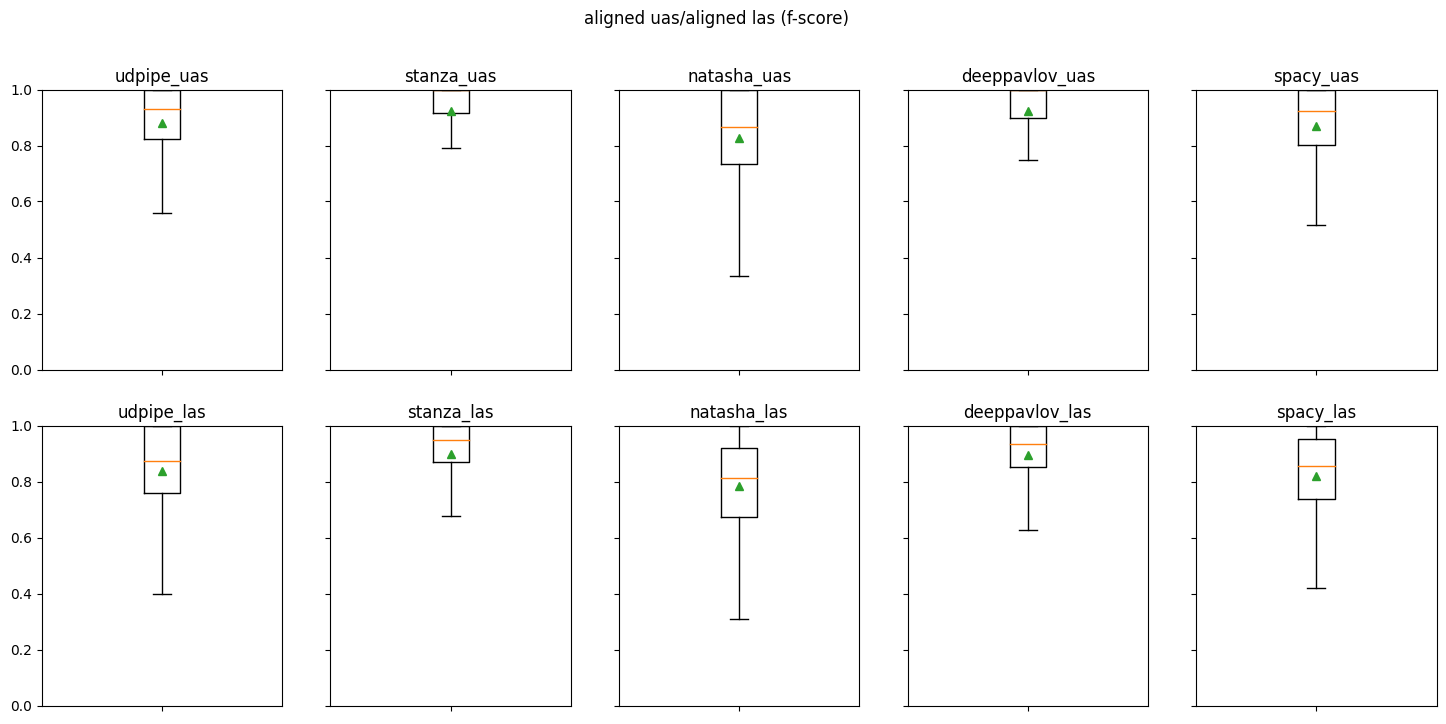

In [82]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=len(parser_names), figsize = (18,8), sharey=True)
fig.suptitle('aligned uas/aligned las (f-score)')

for col_i, p in enumerate(parser_names):
    ax[0][col_i].boxplot(x=align_uas_f[p], showfliers=False,showcaps=True,showmeans=True)
    ax[0][col_i].title.set_text(p + "_uas")
    ax[0][col_i].set_ylim([0.0, 1.0])
    ax[0][col_i].set(xticklabels=[])
    ax[1][col_i].boxplot(x=align_las_f[p], showfliers=False,showcaps=True,showmeans=True)
    ax[1][col_i].title.set_text(p + "_las")
    ax[1][col_i].set_ylim([0.0, 1.0])
    ax[1][col_i].set(xticklabels=[])

plt.show()

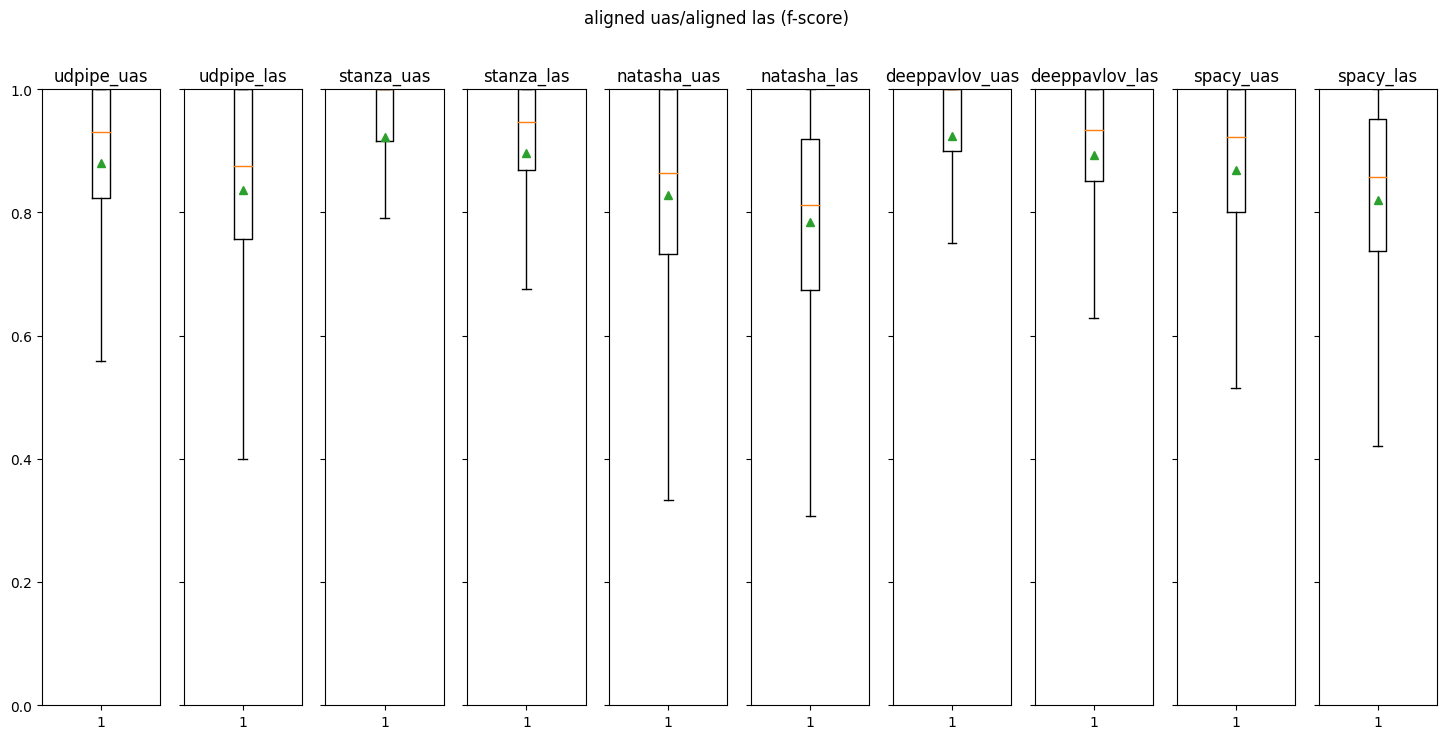

In [79]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=len(parser_names) * 2, figsize = (18,8), sharey=True)
fig.suptitle('aligned uas/aligned las (f-score)')

for col_i, p in enumerate(parser_names):
    ax[2 * col_i].boxplot(x=align_uas_f[p], showfliers=False,showcaps=True,showmeans=True)
    ax[2 * col_i].title.set_text(p + "_uas")
    ax[2 * col_i].set_ylim([0.0, 1.0])
    ax[2 * col_i + 1].boxplot(x=align_las_f[p], showfliers=False,showcaps=True,showmeans=True)
    ax[2 * col_i + 1].title.set_text(p + "_las")
    ax[2 * col_i + 1].set_ylim([0.0, 1.0])


plt.show()

# Token statistics

In [43]:
syntagrus_token_amount = len([t for sent_id in be_syntagrus for t in be_syntagrus[sent_id]])

In [44]:
print(f"syntagrus token amount: {syntagrus_token_amount}")

syntagrus token amount: 157718


In [45]:
for p in parser_names:
  print(f"{p} token amount: {len([t for sent_id in be_res[p] for t in be_res[p][sent_id]])}")

udpipe token amount: 157791
stanza token amount: 157678
natasha token amount: 157194
deeppavlov token amount: 156404
spacy token amount: 158969


## SynTagRus token statistics

In [46]:
import pandas as pd

In [47]:
token_syntagrus_stat = {}
for p in parser_names:
  token_stat_list = []
  for sent_id in sents:
    sent_be = list(be_syntagrus[sent_id].items())
    for token_i, t in enumerate(sents[sent_id].tokens):
      token_be = sent_be[token_i][0]
      synt_parent, synt_relation = sent_be[token_i][1]
      if token_be in be_res[p][sent_id]:
        parser_parent, parser_relation = be_res[p][sent_id][token_be]
        token_stat_list.append((t.form, t.pos, synt_parent==parser_parent,
                          synt_relation==parser_relation, t.relation))
      else:
        token_stat_list.append((t.form, t.pos, None, None, t.relation))

  token_syntagrus_stat[p] = pd.DataFrame(token_stat_list, columns=['form', 'pos', 'parent_match', 'relation_match', "relation"])

In [48]:
extra_syntagrus_any_parsers = set()
for p in parser_names:
  p_extra_syntagrus = set(token_syntagrus_stat[p][token_syntagrus_stat[p]['parent_match'].isnull()].index.values)
  extra_syntagrus_len = len(p_extra_syntagrus)
  extra_syntagrus_any_parsers.update(p_extra_syntagrus)
  print(p, extra_syntagrus_len, round(extra_syntagrus_len / len(token_syntagrus_stat[p]), 3))

udpipe 483 0.003
stanza 437 0.003
natasha 2256 0.014
deeppavlov 2270 0.014
spacy 1968 0.012


In [49]:
len(extra_syntagrus_any_parsers), round(len(extra_syntagrus_any_parsers) / len(token_syntagrus_stat[p]), 3)

(3699, 0.023)

In [50]:
token_syntagrus_stat['stanza']

,form,pos,parent_match,relation_match,relation
0,В,ADP,True,True,case
1,советский,ADJ,True,True,amod
2,период,NOUN,True,True,obl
3,времени,NOUN,True,True,nmod
4,число,NOUN,True,False,obj
...,...,...,...,...,...
157713,она,PRON,True,True,nsubj
157714,и,CCONJ,True,True,cc
157715,застенчиво,ADV,True,True,advmod
157716,улыбнулась,VERB,True,True,conj


### Pos grouping (tokenization by SynTagRus)

In [51]:
from collections import Counter

In [52]:
pos_syntagrus_rate = Counter(t.pos for s in sents.values() for t in s.tokens)

In [53]:
[(p, abs_rate, round(abs_rate / syntagrus_token_amount, 2))
    for (p, abs_rate) in pos_syntagrus_rate.most_common()]

[('NOUN', 36568, 0.23),
 ('PUNCT', 29463, 0.19),
 ('VERB', 18146, 0.12),
 ('ADP', 15062, 0.1),
 ('ADJ', 14471, 0.09),
 ('ADV', 8085, 0.05),
 ('PRON', 8015, 0.05),
 ('PROPN', 5883, 0.04),
 ('CCONJ', 5736, 0.04),
 ('PART', 4921, 0.03),
 ('DET', 4094, 0.03),
 ('SCONJ', 2992, 0.02),
 ('NUM', 2528, 0.02),
 ('AUX', 1518, 0.01),
 ('SYM', 165, 0.0),
 ('X', 48, 0.0),
 ('INTJ', 23, 0.0)]

In [54]:
pos_list = list(map(lambda x: x[0], pos_syntagrus_rate.most_common()))

In [55]:
pos_syntagrus_list = []

for pos in pos_list:
  pos_res = []
  for p in parser_names:
    wrong_tokenization_rate = round(sum(token_syntagrus_stat[p]['parent_match'].isnull() & \
                      (token_syntagrus_stat[p]['pos'] == pos)) / pos_syntagrus_rate[pos] * 100)
    right_tokenization_rate = round(sum((token_syntagrus_stat[p]['parent_match'] == False) & \
                      (token_syntagrus_stat[p]['pos'] == pos)) / pos_syntagrus_rate[pos] * 100)
    parent_rate = round(sum(token_syntagrus_stat[p]['parent_match'] & \
                      (token_syntagrus_stat[p]['relation_match'] == False) & \
                      (token_syntagrus_stat[p]['pos'] == pos)) / pos_syntagrus_rate[pos] * 100)
    relation_rate = round(sum(token_syntagrus_stat[p]['relation_match'] & \
                        token_syntagrus_stat[p]['parent_match'] & \
                       (token_syntagrus_stat[p]['pos'] == pos)) / pos_syntagrus_rate[pos] * 100)
    pos_res.append(f"{wrong_tokenization_rate}, {right_tokenization_rate}, {parent_rate}, {relation_rate}")
  pos_res.append(pos_syntagrus_rate[pos])
  pos_syntagrus_list.append(pos_res)

pos_res = []
token_amount = pos_syntagrus_rate.total()
for p in parser_names:
  wrong_tokenization_rate = round(sum(token_syntagrus_stat[p]['parent_match'].isnull()) \
                                  / token_amount * 100)
  right_tokenization_rate = round(sum((token_syntagrus_stat[p]['parent_match'] == False)) \
                                  / token_amount * 100)
  parent_rate = round(sum(token_syntagrus_stat[p]['parent_match'] & \
                    (token_syntagrus_stat[p]['relation_match'] == False)) \
                          / token_amount * 100)
  relation_rate = round(sum(token_syntagrus_stat[p]['relation_match'] & \
                      token_syntagrus_stat[p]['parent_match']) \
                         / token_amount * 100)
  pos_res.append(f"{wrong_tokenization_rate}, {right_tokenization_rate}, {parent_rate}, {relation_rate}")
pos_res.append(pos_syntagrus_rate.total())
pos_syntagrus_list.append(pos_res)

pos_syntagrus = pd.DataFrame(pos_syntagrus_list,
                             index=pos_list + ["all pos tags"],
                             columns=[f"{p} (%)" for p in parser_names] + ["all token amount"])

Every cell is formatted as (wrong token amount, right token amount, right parent amount, right relation amount)

In [56]:
pos_syntagrus

,udpipe (%),stanza (%),natasha (%),deeppavlov (%),spacy (%),all token amount
NOUN,"0, 15, 6, 78","0, 8, 4, 87","1, 22, 6, 71","1, 7, 3, 89","1, 12, 6, 81",36568
PUNCT,"0, 19, 0, 81","0, 11, 0, 89","2, 25, 0, 73","3, 13, 0, 85","1, 20, 3, 76",29463
VERB,"0, 16, 3, 81","0, 8, 2, 90","0, 27, 3, 69","0, 6, 2, 91","0, 13, 3, 84",18146
ADP,"0, 2, 0, 97","0, 2, 0, 98","0, 5, 0, 95","0, 2, 0, 98","0, 3, 0, 96",15062
ADJ,"0, 7, 6, 86","0, 4, 2, 93","1, 13, 4, 82","1, 3, 6, 90","1, 7, 4, 89",14471
ADV,"0, 15, 8, 77","0, 9, 7, 83","0, 21, 14, 65","0, 9, 8, 83","3, 13, 14, 70",8085
PRON,"0, 10, 8, 82","0, 8, 5, 87","0, 15, 6, 79","0, 5, 6, 89","2, 9, 6, 82",8015
PROPN,"1, 15, 8, 76","1, 8, 4, 87","10, 18, 6, 66","7, 6, 4, 83","7, 13, 7, 74",5883
CCONJ,"0, 10, 1, 89","0, 5, 1, 94","0, 19, 1, 80","0, 4, 1, 95","0, 10, 2, 88",5736
PART,"0, 12, 7, 81","0, 12, 3, 85","1, 17, 4, 79","1, 10, 5, 85","1, 15, 4, 80",4921


In [57]:
token_syntagrus_stat[p][token_syntagrus_stat[p]['parent_match'].isnull() &
                       (token_syntagrus_stat[p]['pos'] == 'PROPN')]

,form,pos,parent_match,relation_match,relation
5,ИТ,PROPN,None,None,compound
2398,ИТ,PROPN,None,None,compound
2654,ИТ,PROPN,None,None,compound
5812,Мельникова-Печерского,PROPN,None,None,flat:name
10728,Чио-Сан,PROPN,None,None,obl
...,...,...,...,...,...
137574,Сен-Мало,PROPN,None,None,nmod
137619,Мон-Сен-Мишель,PROPN,None,None,nsubj
137651,Мон-Сен-Мишеля,PROPN,None,None,obl
137787,Сен-Мало,PROPN,None,None,obl


### Relation grouping (tokenization by SynTagRus)

In [58]:
relation_syntagrus_rate = Counter(t.relation for s in sents.values() for t in s.tokens)
relation_list = list(map(lambda x: x[0], relation_syntagrus_rate.most_common()))

In [59]:
[(p, abs_rate, round(abs_rate / syntagrus_token_amount, 2))
    for (p, abs_rate) in relation_syntagrus_rate.most_common()]

[('punct', 29463, 0.19),
 ('case', 14943, 0.09),
 ('obl', 13272, 0.08),
 ('nmod', 12179, 0.08),
 ('amod', 11954, 0.08),
 ('nsubj', 10416, 0.07),
 ('advmod', 9860, 0.06),
 ('root', 8800, 0.06),
 ('conj', 7640, 0.05),
 ('cc', 5869, 0.04),
 ('obj', 5124, 0.03),
 ('det', 3752, 0.02),
 ('parataxis', 3285, 0.02),
 ('mark', 2804, 0.02),
 ('advcl', 1810, 0.01),
 ('xcomp', 1615, 0.01),
 ('acl', 1581, 0.01),
 ('fixed', 1445, 0.01),
 ('iobj', 1425, 0.01),
 ('appos', 1371, 0.01),
 ('nummod', 1185, 0.01),
 ('nsubj:pass', 1129, 0.01),
 ('acl:relcl', 1012, 0.01),
 ('flat:name', 976, 0.01),
 ('ccomp', 865, 0.01),
 ('csubj', 863, 0.01),
 ('cop', 729, 0.0),
 ('aux:pass', 476, 0.0),
 ('nummod:gov', 380, 0.0),
 ('aux', 312, 0.0),
 ('flat:foreign', 234, 0.0),
 ('orphan', 171, 0.0),
 ('flat', 164, 0.0),
 ('compound', 141, 0.0),
 ('discourse', 116, 0.0),
 ('expl', 100, 0.0),
 ('obl:tmod', 76, 0.0),
 ('nummod:entity', 57, 0.0),
 ('obl:agent', 56, 0.0),
 ('csubj:pass', 34, 0.0),
 ('vocative', 32, 0.0),
 ('nsub

In [60]:
relation_extra_syntagrus_list = []
for relation in relation_list:
  rel_res = []
  for p in parser_names:
    wrong_tokenization_rate = round(sum(token_syntagrus_stat[p]['parent_match'].isnull() & \
                      (token_syntagrus_stat[p]['relation'] == relation)) / relation_syntagrus_rate[relation] * 100)
    right_tokenization_rate = round(sum((token_syntagrus_stat[p]['parent_match'] == False) & \
                      (token_syntagrus_stat[p]['relation'] == relation)) / relation_syntagrus_rate[relation] * 100)
    parent_rate = round(sum(token_syntagrus_stat[p]['parent_match'] & \
                      (token_syntagrus_stat[p]['relation_match'] == False) & \
                      (token_syntagrus_stat[p]['relation'] == relation)) / relation_syntagrus_rate[relation] * 100)
    relation_rate = round(sum(token_syntagrus_stat[p]['relation_match'] & \
                        token_syntagrus_stat[p]['parent_match'] & \
                       (token_syntagrus_stat[p]['relation'] == relation)) / relation_syntagrus_rate[relation] * 100)
    rel_res.append(f"{wrong_tokenization_rate}, {right_tokenization_rate}, {parent_rate}, {relation_rate}")
  rel_res.append(relation_syntagrus_rate[relation])
  relation_extra_syntagrus_list.append(rel_res)

rel_res = []
token_amount = relation_syntagrus_rate.total()
for p in parser_names:
  wrong_tokenization_rate = round(sum(token_syntagrus_stat[p]['parent_match'].isnull()) \
                                  / token_amount * 100)
  right_tokenization_rate = round(sum((token_syntagrus_stat[p]['parent_match'] == False)) \
                                  / token_amount * 100)
  parent_rate = round(sum(token_syntagrus_stat[p]['parent_match'] & \
                    (token_syntagrus_stat[p]['relation_match'] == False)) \
                          / token_amount * 100)
  relation_rate = round(sum(token_syntagrus_stat[p]['relation_match'] & \
                      token_syntagrus_stat[p]['parent_match']) \
                         / token_amount * 100)
  rel_res.append(f"{wrong_tokenization_rate}, {right_tokenization_rate}, {parent_rate}, {relation_rate}")
rel_res.append(token_amount)
relation_extra_syntagrus_list.append(rel_res)

rel_syntagrus = pd.DataFrame(relation_extra_syntagrus_list,
                             index=relation_list + ["all relations"],
                             columns=[f"{p} (%)" for p in parser_names] + ["relation token amount"])

In [61]:
rel_syntagrus

,udpipe (%),stanza (%),natasha (%),deeppavlov (%),spacy (%),relation token amount
punct,"0, 19, 0, 81","0, 11, 0, 89","2, 25, 0, 73","3, 13, 0, 85","1, 20, 3, 76",29463
case,"0, 2, 1, 97","0, 2, 1, 97","0, 5, 0, 95","0, 2, 1, 98","0, 3, 0, 97",14943
obl,"0, 14, 5, 80","0, 9, 4, 87","1, 20, 18, 61","1, 6, 4, 89","1, 10, 18, 70",13272
nmod,"1, 14, 5, 81","0, 9, 3, 88","3, 17, 3, 77","3, 6, 3, 88","2, 12, 3, 83",12179
amod,"0, 3, 5, 91","0, 3, 1, 96","1, 8, 1, 90","1, 2, 5, 93","1, 3, 1, 95",11954
nsubj,"0, 10, 6, 84","0, 5, 2, 93","1, 16, 5, 78","0, 4, 2, 94","1, 8, 3, 88",10416
advmod,"0, 11, 7, 82","0, 9, 6, 85","0, 17, 4, 79","0, 8, 5, 87","2, 11, 4, 83",9860
root,"0, 10, 0, 90","0, 4, 0, 96","0, 15, 0, 85","1, 4, 0, 95","0, 9, 0, 91",8800
conj,"0, 30, 2, 68","0, 14, 1, 85","1, 44, 3, 52","1, 12, 2, 86","1, 23, 3, 74",7640
cc,"0, 10, 2, 87","0, 6, 1, 94","0, 19, 2, 79","0, 5, 2, 93","0, 10, 3, 87",5869


In [62]:
token_syntagrus_stat["spacy"][((token_syntagrus_stat["spacy"]["relation"] == "flat:name") &
                               token_syntagrus_stat["spacy"]["parent_match"].isnull())]

,form,pos,parent_match,relation_match,relation
5812,Мельникова-Печерского,PROPN,None,None,flat:name
11028,М.,PROPN,None,None,flat:name
11199,В.,PROPN,None,None,flat:name
34363,Матросов,PROPN,None,None,flat:name
41108,А.,PROPN,None,None,flat:name
...,...,...,...,...,...
132918,Апресяна,PROPN,None,None,flat:name
132921,М.,PROPN,None,None,flat:name
132922,Богуславского,PROPN,None,None,flat:name
132925,Л.,PROPN,None,None,flat:name


In [63]:
Counter(token_syntagrus_stat[p][token_syntagrus_stat[p]['parent_match'].isnull()].pos)

Counter({'PROPN': 422,
         'PUNCT': 319,
         'NUM': 218,
         'ADP': 62,
         'X': 4,
         'ADJ': 77,
         'NOUN': 279,
         'VERB': 17,
         'PRON': 170,
         'ADV': 239,
         'PART': 38,
         'DET': 114,
         'INTJ': 3,
         'SCONJ': 1,
         'CCONJ': 5})

In [64]:
for p in parser_names:
  differ_tokenisation = token_syntagrus_stat[p][token_syntagrus_stat[p]['parent_match'].isnull()]
  print(p, [(t, round(r / len(differ_tokenisation), 2)) for t, r in Counter(differ_tokenisation.pos).most_common()])

udpipe [('NOUN', 0.28), ('PUNCT', 0.23), ('PROPN', 0.18), ('ADJ', 0.14), ('NUM', 0.07), ('ADV', 0.03), ('VERB', 0.02), ('PRON', 0.02), ('X', 0.01), ('PART', 0.01), ('DET', 0.01), ('ADP', 0.0), ('SYM', 0.0), ('INTJ', 0.0)]
stanza [('NOUN', 0.27), ('PUNCT', 0.26), ('ADJ', 0.15), ('PROPN', 0.09), ('NUM', 0.09), ('ADV', 0.05), ('VERB', 0.02), ('PRON', 0.02), ('PART', 0.02), ('X', 0.01), ('CCONJ', 0.01), ('DET', 0.0), ('ADP', 0.0)]
natasha [('PUNCT', 0.27), ('PROPN', 0.26), ('NUM', 0.21), ('NOUN', 0.14), ('ADJ', 0.07), ('ADV', 0.02), ('VERB', 0.01), ('PART', 0.01), ('PRON', 0.01), ('X', 0.0), ('CCONJ', 0.0), ('DET', 0.0), ('ADP', 0.0)]
deeppavlov [('PUNCT', 0.33), ('NUM', 0.21), ('PROPN', 0.18), ('NOUN', 0.14), ('ADJ', 0.07), ('VERB', 0.02), ('ADV', 0.02), ('PART', 0.01), ('PRON', 0.01), ('CCONJ', 0.01), ('X', 0.0), ('DET', 0.0), ('ADP', 0.0), ('SCONJ', 0.0), ('SYM', 0.0)]
spacy [('PROPN', 0.21), ('PUNCT', 0.16), ('NOUN', 0.14), ('ADV', 0.12), ('NUM', 0.11), ('PRON', 0.09), ('DET', 0.06), (

## Parser token statistics

In [65]:
token_parser_stat = {}
for p in parser_names:
  token_stat_list = []
  for sent_id in res[p]:
    parser_sent_be = list(be_res[p][sent_id].items())
    for token_i, t in enumerate(res[p][sent_id].tokens):
      token_be = parser_sent_be[token_i][0]
      parser_parent, parser_relation = parser_sent_be[token_i][1]
      if token_be in be_syntagrus[sent_id]:
        synt_parent, synt_relation = be_syntagrus[sent_id][token_be]
        token_stat_list.append((sent_id, token_i, synt_parent==parser_parent,
                          synt_relation==parser_relation))
      else:
        token_stat_list.append((sent_id, token_i, None, None))

  token_parser_stat[p] = pd.DataFrame(token_stat_list, columns=['sent_id', 'token_i', 'parent_match', 'relation_match'])

In [66]:
token_parser_stat['stanza']

,sent_id,token_i,parent_match,relation_match
0,2003Armeniya.xml_1,0,True,True
1,2003Armeniya.xml_1,1,True,True
2,2003Armeniya.xml_1,2,True,True
3,2003Armeniya.xml_1,3,True,True
4,2003Armeniya.xml_1,4,True,False
...,...,...,...,...
157673,2020_RFFIMoskva_2042.xml_742,9,True,True
157674,2020_RFFIMoskva_2042.xml_742,10,True,True
157675,2020_RFFIMoskva_2042.xml_742,11,True,True
157676,2020_RFFIMoskva_2042.xml_742,12,True,True


In [67]:
for p in parser_names:
  extra_parser_len = sum(token_parser_stat[p]['parent_match'].isnull())
  print(p, extra_parser_len, round(extra_parser_len / len(token_parser_stat[p]), 3))

udpipe 556 0.004
stanza 397 0.003
natasha 1732 0.011
deeppavlov 956 0.006
spacy 3219 0.02


In [68]:
[(t.parent_id, t.relation) for t in res["deeppavlov"]['2013Ataman_Vikhr.xml_48'].tokens]

[('4', 'nsubj'),
 ('4', 'cop'),
 ('4', 'amod'),
 ('0', 'root'),
 ('6', 'amod'),
 ('4', 'nmod'),
 ('9', 'case'),
 ('9', 'amod'),
 ('4', 'nmod'),
 ('4', 'punct')]

In [69]:
[(t.parent_id, t.relation) for t in res["stanza"]['2013Ataman_Vikhr.xml_48'].tokens]

[('4', 'nsubj'),
 ('4', 'cop'),
 ('4', 'amod'),
 ('0', 'root'),
 ('6', 'amod'),
 ('4', 'nmod'),
 ('9', 'case'),
 ('9', 'amod'),
 ('4', 'nmod'),
 ('4', 'punct')]

In [70]:
for p in parser_names:
  t_amount = len([t for s in res[p].values() for t in s.tokens])
  print(p, [(r, abs_rate, round(abs_rate / t_amount, 2))
           for r, abs_rate in Counter(t.relation for s in res[p].values() for t in s.tokens).most_common()])

udpipe [('punct', 29518, 0.19), ('case', 14864, 0.09), ('obl', 14143, 0.09), ('nmod', 12140, 0.08), ('amod', 11542, 0.07), ('nsubj', 10459, 0.07), ('advmod', 9666, 0.06), ('root', 8858, 0.06), ('conj', 7848, 0.05), ('cc', 5853, 0.04), ('obj', 4691, 0.03), ('det', 3654, 0.02), ('parataxis', 3174, 0.02), ('mark', 3097, 0.02), ('nummod', 2200, 0.01), ('advcl', 1792, 0.01), ('xcomp', 1641, 0.01), ('acl', 1501, 0.01), ('fixed', 1291, 0.01), ('iobj', 1244, 0.01), ('appos', 1091, 0.01), ('acl:relcl', 1026, 0.01), ('nsubj:pass', 1019, 0.01), ('flat:name', 916, 0.01), ('ccomp', 830, 0.01), ('cop', 779, 0.0), ('csubj', 778, 0.0), ('nummod:gov', 677, 0.0), ('aux:pass', 454, 0.0), ('aux', 322, 0.0), ('flat:foreign', 238, 0.0), ('flat', 151, 0.0), ('discourse', 123, 0.0), ('compound', 95, 0.0), ('orphan', 80, 0.0), ('csubj:pass', 28, 0.0), ('nummod:entity', 6, 0.0), ('expl', 2, 0.0)]
stanza [('punct', 29299, 0.19), ('case', 14849, 0.09), ('obl', 13954, 0.09), ('amod', 12063, 0.08), ('nmod', 12040, 